<a href="https://colab.research.google.com/github/caarolgomesds/QM9_Chemical_Analysis/blob/main/Deliverable_5_Active_Learning_(Part_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deliverable 5: Active Learning (Part 1 – Baseline)**

This notebook establishes the baseline for predicting molecular properties in the QM9 dataset. This step is essential for enabling future comparisons with the performance of Active Learning models.

**Objective:** To develop and evaluate an MLP machine learning model for predicting the atomization energy ($U_0$) of QM9 molecules using Coulomb Matrix (CM) descriptors.

# **1. Setup and Library Imports**

This section imports all libraries required for the project. They are organized by functionality:

**1. Data Handling**

Used for loading, storing, and manipulating the dataset.

* pandas: Provides tabular data structures (DataFrames).

* numpy: Supports numerical arrays and mathematical operations.

**2. Cheminformatics**

Used for processing molecular structures and generating descriptors.

* rdkit: Reads molecular representations (e.g., SMILES) and generates 3D geometries.

* dscribe: Computes 3D molecular descriptors, specifically the Coulomb Matrix.

* ase (Atomic Simulation Environment): Creates atomic objects used as input for descriptor generation with dscribe.

**3. Machine Learning (scikit-learn)**

Used to build, train, and evaluate the model. (This section adapts to the use of an MLP.)

* model_selection: Tools for dataset splitting (train/test) and hyperparameter optimization (e.g., RandomizedSearchCV).

* pipeline: Builds preprocessing pipelines (e.g., integrating StandardScaler with the model).

* preprocessing: Provides data normalization tools (e.g., StandardScaler).

* neural_network: Contains the regression model used in this study (MLPRegressor).

* metrics: Computes evaluation metrics (MAE, R²).

* learning_curve: Generates the learning curve for performance analysis.

In [ ]:
## 1. Setup and Library Imports

# This line ensures all base dependencies are installed.
!pip install rdkit mordred pandas glob tqdm scikit-learn matplotlib seaborn numpy

# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import sys
import tarfile
import requests
import glob
from pathlib import Path
from tqdm.notebook import tqdm  # Use the notebook version of tqdm

# Cheminformatics (RDKit and Mordred)
try:
    from rdkit import Chem
    from rdkit.Chem import AllChem
    from mordred import Calculator, descriptors
    print("RDKit and Mordred loaded.")
except ImportError:
    print("Installing RDKit and Mordred...")
    !pip install rdkit mordred
    from rdkit import Chem
    from rdkit.Chem import AllChem
    from mordred import Calculator, descriptors
    print("RDKit and Mordred installed and loaded.")

# Machine Learning (Scikit-learn)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import learning_curve

# Visual settings
sns.set_style("whitegrid")
%matplotlib inline

ERROR: Could not find a version that satisfies the requirement glob (from versions: none)
ERROR: No matching distribution found for glob
RDKit and Mordred loaded.


# **2. Download and Processing of the Data (Original QM9)**


**2.1. Download and Extraction Functions**

In [ ]:
import os
import requests
import pandas as pd
from tqdm.notebook import tqdm # Optimized version for notebooks

# --- 1. Download Function Definition ---

def download_file(url, save_path):
    """Downloads a file with a progress bar (Original logic)."""
    print(f"Downloading '{os.path.basename(save_path)}'...")
    try:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            total_size = int(r.headers.get('content-length', 0))
            with open(save_path, 'wb') as f, tqdm(
                desc=os.path.basename(save_path), total=total_size, unit='iB',
                unit_scale=True, unit_divisor=1024,
            ) as bar:
                for chunk in r.iter_content(chunk_size=8192):
                    size = f.write(chunk)
                    bar.update(size)
        return True
    except requests.exceptions.RequestException as e:
        print(f"Error during download of {url}: {e}")
        return False

## 2. Data Loading and Preparation (CSV)

print("Downloading the qm9.csv dataset (updated link)...")

# --- Dataset URL ---
CSV_URL = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv"

try:
    # Download the CSV file using the URL
    # The -O qm9.csv flag ensures the filename is 'qm9.csv'
    !wget -q -O qm9.csv {CSV_URL}

    # Load the downloaded CSV
    data = pd.read_csv("qm9.csv")

    # Keep only the columns we need
    # 'u0' is our target property
    data = data[['smiles', 'u0']].copy()

    data.rename(columns={'smiles': 'SMILES', 'u0': 'Target'}, inplace=True)
    print(f"Dataset loaded successfully. Total of {len(data)} molecules.")
    data.head()

except Exception as e:
    print(f"Failed to download or read the CSV: {e}")

Dataset loaded successfully. Total of 133885 molecules.


**2.2. RDKit Molecule Generation and Cleanup**

Now that we have the SMILES, we can generate RDKit mol objects. These objects will be used to generate the 3D geometries required for the descriptors.

In [ ]:
# Function to convert SMILES to mol (and check validity)
def get_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return mol
    return None

start_time = time.time()
data['mol'] = data['SMILES'].apply(get_mol)

# Remove invalid SMILES (if any)
data = data.dropna(subset=['mol'])
print(f"RDKit molecules generated in {time.time() - start_time:.2f}s")
print(f"Final dataset size: {len(data)} molecules")
data.head()

RDKit molecules generated in 21.86s
Final dataset size: 133885 molecules


,SMILES,Target,mol
0,C,-40.478930,<rdkit.Chem.rdchem.Mol object at 0x794b81eaae30>
1,N,-56.525887,<rdkit.Chem.rdchem.Mol object at 0x794b81eaaea0>
2,O,-76.404702,<rdkit.Chem.rdchem.Mol object at 0x794b81eab3e0>
3,C#C,-77.308427,<rdkit.Chem.rdchem.Mol object at 0x794b81eab450>
4,C#N,-93.411888,<rdkit.Chem.rdchem.Mol object at 0x794b81eab4c0>


# **3. Descriptor Generation**

**3.1. Representation Selection**

In [ ]:
## 3. Descriptor Generation (Coulomb Matrix with dscribe)

print("Installing 'rdkit', 'dscribe', and 'ase'...")
!pip install rdkit dscribe ase

from dscribe.descriptors import CoulombMatrix
from ase import Atoms
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import os

# --- Conversion Function (rdkit_to_ase) ---
def rdkit_to_ase(mol):
    """Converts RDKit.Mol to ASE.Atoms."""
    try:
        conformer = mol.GetConformer(0)
    except ValueError:
        return None
    symbols = [atom.GetSymbol() for atom in mol.GetAtoms()]
    positions = conformer.GetPositions()
    return Atoms(symbols=symbols, positions=positions)
# ----------------------------------------

# --- 1. Prepare Molecules (Generate 3D) ---
# (This part was already executed, but is included for completeness)
data_to_process = data
ase_mols = []
valid_indices = []

print("Generating 3D Conformers and converting to ASE...")
for index, row in tqdm(data_to_process.iterrows(), total=len(data_to_process)):
    mol = row['mol']
    mol_h = Chem.AddHs(mol)
    status = AllChem.EmbedMolecule(mol_h, AllChem.ETKDGv3())

    if status == 0 and mol_h.GetNumConformers() > 0:
        try:
            AllChem.MMFFOptimizeMolecule(mol_h)
            ase_mol = rdkit_to_ase(mol_h)
            if ase_mol:
                ase_mols.append(ase_mol)
                valid_indices.append(index)
        except (ValueError, TypeError):
            pass

print(f"3D geometries generated and converted to ASE: {len(ase_mols)} valid molecules.")

# --- 2. Configure and Calculate Coulomb Matrix ---
print("Configuring the CM descriptor...")
cm_desc = CoulombMatrix(
    n_atoms_max=29
    # The 'flatten' argument is not needed here
)

print("Calculating the Coulomb Matrix...")
start_time = time.time()

# X_cm_raw will already be 2D (N_molecules, N_features)
X_cm_raw = cm_desc.create(ase_mols, n_jobs=-1)

print(f"CM calculation completed in {time.time() - start_time:.2f}s")

# --- 3. Cleanup and Definition of X and y ---
print("Defining X and y (Manual flattening is not necessary)...")

# The manual flattening step (with np.triu_indices) was removed.
# X_cm_raw is already our X.
X_cm_flat = np.nan_to_num(X_cm_raw) # We just clean up NaNs

X = X_cm_flat # Our final X
y = data_to_process.loc[valid_indices]['Target'].values

print(f"\nFinal descriptor shape (X): {X.shape}")
print(f"Final target shape (y): {y.shape}")

Installing 'rdkit', 'dscribe', and 'ase'...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.4/777.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 23.0 MB/s eta 0:00:00
Generating 3D Conformers and converting to ASE...


  0%|          | 0/133885 [00:00<?, ?it/s]

3D geometries generated and converted to ASE: 131489 valid molecules.
Configuring the CM descriptor...
Calculating the Coulomb Matrix...
CM calculation completed in 7.13s
Defining X and y (Manual flattening is not necessary)...

Final descriptor shape (X): (131489, 841)
Final target shape (y): (131489,)


# **4. Topline Predictor Setup (MLP)**

**4.1. Dataset Split (80/10/10)**

In [ ]:
# Split 80% (Train) and 20% (Validation + Test)
X_train_full, X_val_test, y_train_full, y_val_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Split the 20% into 10% (Validation) and 10% (Test)
X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test, test_size=0.5, random_state=42
)

print(f"Total dataset: {len(X)}")
print(f"Training set (80%): {len(X_train_full)}")
print(f"Validation set (10%): {len(X_val)}")
print(f"Test set (10%): {len(X_test)}")

Total dataset: 131489
Training set (80%): 105191
Validation set (10%): 13149
Test set (10%): 13149


**4.2 Model Imports (MLP)**

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import learning_curve

# --- Required imports ---
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
# --------------------------------

print("MLP modules (Pipeline, StandardScaler, MLPRegressor) imported.")

MLP modules (Pipeline, StandardScaler, MLPRegressor) imported.


**4.3. Pipeline Creation and Hyperparameter Tuning (MLP)**

Here we create a Pipeline that first applies the StandardScaler and then trains the MLPRegressor.

In [ ]:
# 1. Create the Pipeline
# max_iter=1000 ensures the network has time to converge
# early_stopping=True and n_iter_no_change=10 help stop training
# if the (internal) validation score doesn't improve, which speeds up tuning.
pipe_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(random_state=42,
                         max_iter=1000,
                         early_stopping=True,
                         n_iter_no_change=10))
])

# 2. Search space for the MLP
# (We use 'mlp__' to reference parameters inside the pipeline)
param_dist = {
    'mlp__hidden_layer_sizes': [(100,), (100, 50), (50, 50, 50)], # Network architecture
    'mlp__activation': ['relu'], # 'relu' is almost always the best choice
    'mlp__solver': ['adam'],
    'mlp__alpha': [0.0001, 0.001, 0.01], # L2 regularization
    'mlp__learning_rate_init': [0.001, 0.005, 0.01] # Learning rate
}

# 3. Configure the randomized search
random_search = RandomizedSearchCV(
    estimator=pipe_mlp,
    param_distributions=param_dist,
    n_iter=10, # 10 random combinations (increase if you have time)
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

print("Starting MLP hyperparameter tuning (this may take time)...")
start_time = time.time()

# We use X_train_full (80%) for tuning
# The pipeline handles scaling within each CV fold
random_search.fit(X_train_full, y_train_full)
print(f"Tuning completed in {time.time() - start_time:.2f}s")

# Best parameters found
print("\nBest Hyperparameters (Pipeline):")
print(random_search.best_params_)

# Final model (the best pipeline)
best_mlp_pipeline = random_search.best_estimator_

Starting MLP hyperparameter tuning (this may take time)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Tuning completed in 2371.11s

Best Hyperparameters (Pipeline):
{'mlp__solver': 'adam', 'mlp__learning_rate_init': 0.001, 'mlp__hidden_layer_sizes': (100,), 'mlp__alpha': 0.001, 'mlp__activation': 'relu'}


# **5. Final Evaluation (Test Set)**

**5.1. Evaluate the final model with the Test Set**

The evaluation process is the same, but now we use the best_mlp_pipeline.

In [ ]:
# Make predictions on the Test set
# The pipeline applies scaling (learned on X_train_full)
# and then makes the prediction with the MLP
y_pred_test = best_mlp_pipeline.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)

print("--- MLP Evaluation Metrics on Test Set (10%) ---")
print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"R² (Coefficient of Determination): {r2:.4f}")

# Store results for plotting
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test})

--- MLP Evaluation Metrics on Test Set (10%) ---
MAE (Mean Absolute Error): 0.7339
RMSE (Root Mean Squared Error): 1.2254
R² (Coefficient of Determination): 0.9991


**5.2. Results Visualization**

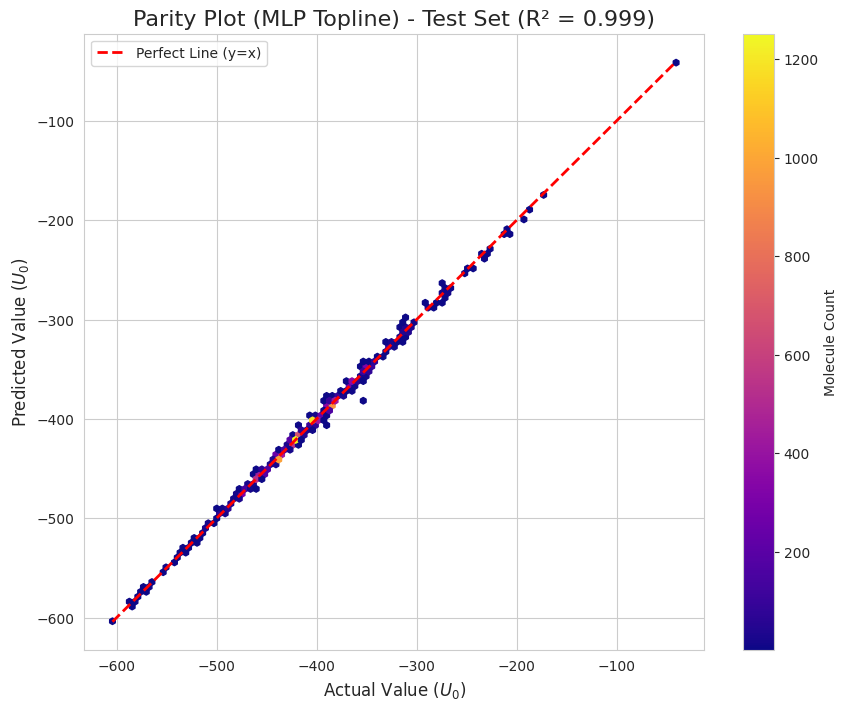

In [ ]:
# Plot 1: Parity Plot (Predicted vs. Actual)

plt.figure(figsize=(10, 8))
# Use 'Actual' and 'Predicted' keys based on the previous translation
plt.hexbin(results['Actual'], results['Predicted'], gridsize=100, cmap='plasma', mincnt=1)

min_val = min(results['Actual'].min(), results['Predicted'].min())
max_val = max(results['Actual'].max(), results['Predicted'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Line (y=x)')

# Updated title
plt.title(f'Parity Plot (MLP Topline) - Test Set (R² = {r2:.3f})', fontsize=16)
plt.xlabel('Actual Value ($U_0$)', fontsize=12)
plt.ylabel('Predicted Value ($U_0$)', fontsize=12)
plt.legend()
plt.colorbar(label='Molecule Count')
plt.show()

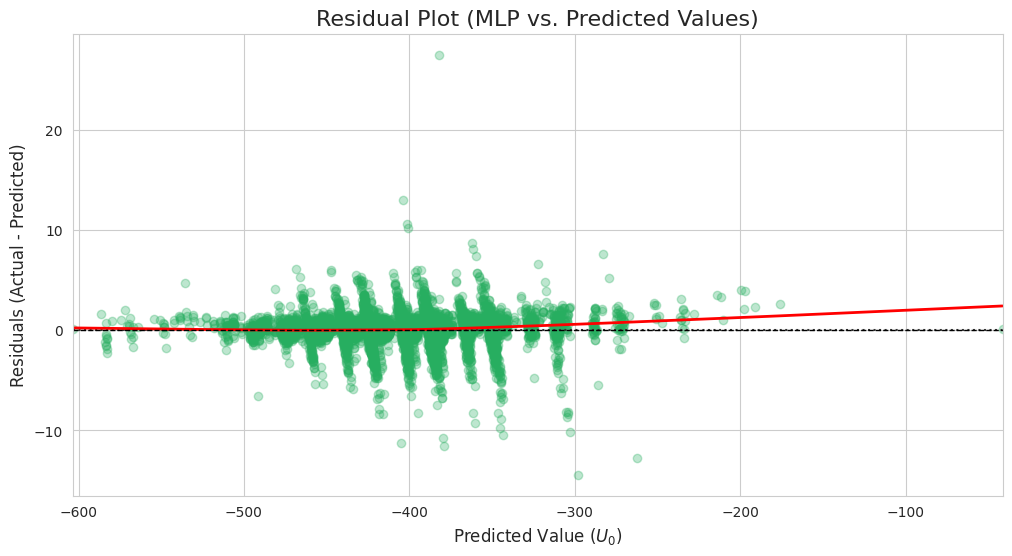

In [ ]:
# Plot 2: Residual Plot

results['Residuals'] = results['Actual'] - results['Predicted']
plt.figure(figsize=(12, 6))
sns.residplot(data=results, x='Predicted', y='Residuals',
              lowess=True,
              scatter_kws={'alpha': 0.3, 'color': '#27ae60'},
              line_kws={'color': 'red', 'lw': 2})

plt.axhline(y=0, linestyle='--', color='black', linewidth=1)
plt.title('Residual Plot (MLP vs. Predicted Values)', fontsize=16)
plt.xlabel('Predicted Value ($U_0$)', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
plt.show()

# **6. Additional Analyses (MLP)**

**6.1. Descriptor Importance (Permutation Importance)**

The best alternative is to use Permutation Importance, which works for any model.

This technique measures the importance of a feature by shuffling its values in the test set and observing how much the model's score (e.g., R²) degrades.

Calculating Permutation Importance (on Test Set)...
Calculation completed in 1239.58s


/tmp/ipython-input-1258193206.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


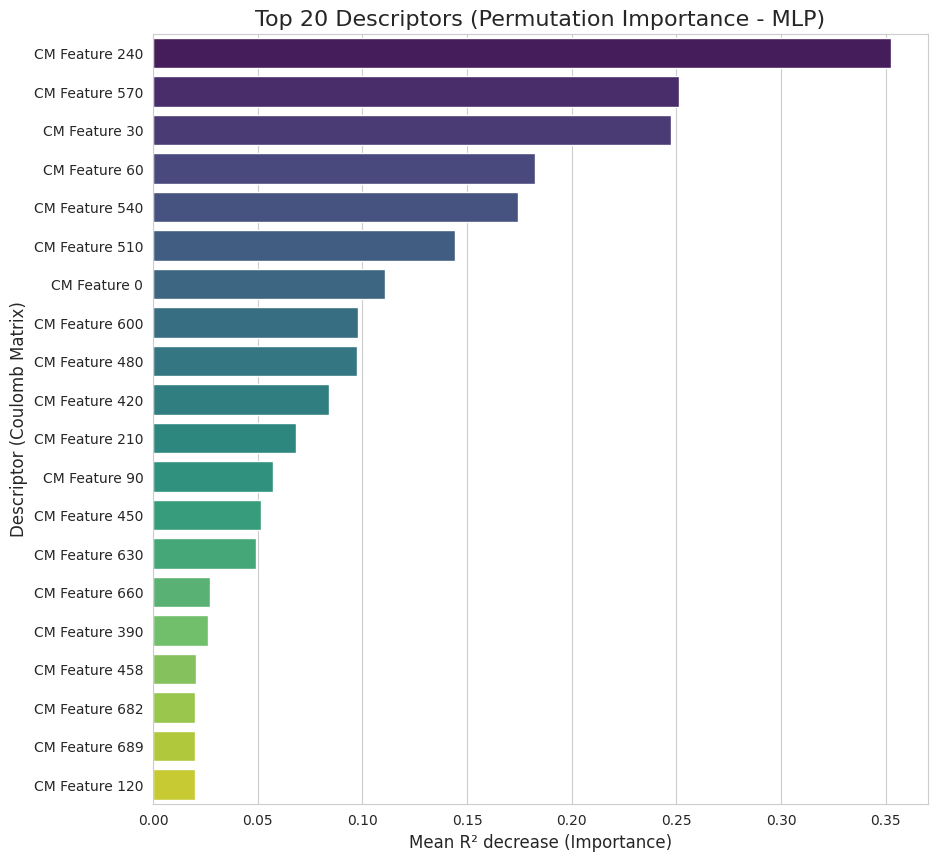

In [ ]:
## 6.1. Descriptor Importance (Permutation Importance)

from sklearn.inspection import permutation_importance

print("Calculating Permutation Importance (on Test Set)...")
start_time = time.time()

r = permutation_importance(
    best_mlp_pipeline,
    X_test,
    y_test,
    n_repeats=10, # Repeat 10x for stability
    random_state=42,
    n_jobs=-1
)
print(f"Calculation completed in {time.time() - start_time:.2f}s")

# --- START OF MODIFICATION ---
# Create generic names for the Coulomb Matrix features
# Our X (descriptors) has no column names, so we create a list
n_features = X.shape[1] # Get the number of features (e.g., 841)
feature_names = [f'CM Feature {i}' for i in range(n_features)]

# Organize results using the generic names
df_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance_mean': r.importances_mean,
    'Importance_std': r.importances_std
}).sort_values(by='Importance_mean', ascending=False)
# --- END OF MODIFICATION ---


# Plot the Top 20 most important features
plt.figure(figsize=(10, 10))
sns.barplot(
    x='Importance_mean',
    y='Feature',
    data=df_importance.head(20),
    palette='viridis'
)
plt.title('Top 20 Descriptors (Permutation Importance - MLP)', fontsize=16)
plt.xlabel('Mean R² decrease (Importance)', fontsize=12)
plt.ylabel('Descriptor (Coulomb Matrix)', fontsize=12)
plt.show()

Active Learning

In [ ]:
import pandas as pd
import numpy as np
import requests
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from copy import deepcopy
import matplotlib.pyplot as plt

# Tentar importar bibliotecas de Quimioinformática
try:
    from dscribe.descriptors import CoulombMatrix
    from ase import Atoms
    from rdkit import Chem
    from rdkit.Chem import AllChem
    RDKIT_AVAILABLE = True
    print("RDKit / dscribe imports successful.")
except ImportError:
    RDKIT_AVAILABLE = False
    # Definir placeholders para classes RDKit/ASE se não estiverem disponíveis
    class Atoms: pass
    class CoulombMatrix: pass
    print("AVISO: RDKit/dscribe não disponível. Usando Feature Engineering simulado.")

# --- 1. CONFIGURAÇÃO E DOWNLOAD DE DADOS ---
# URL do dataset QM9
CSV_URL = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv"
FILE_PATH = "qm9.csv"

def download_file(url, save_path):
    """Downloads a file."""
    print(f"Downloading '{os.path.basename(save_path)}'...")
    try:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            total_size = int(r.headers.get('content-length', 0))
            with open(save_path, 'wb') as f, tqdm(
                desc=os.path.basename(save_path), total=total_size, unit='iB',
                unit_scale=True, unit_divisor=1024, disable=False
            ) as bar:
                for chunk in r.iter_content(chunk_size=8192):
                    size = f.write(chunk)
                    bar.update(size)
        return True
    except requests.exceptions.RequestException as e:
        print(f"Error during download of {url}: {e}")
        return False

# Download e carregamento (assume que o arquivo já foi baixado ou tenta baixar)
if not os.path.exists(FILE_PATH):
    download_file(CSV_URL, FILE_PATH)

try:
    data_raw = pd.read_csv(FILE_PATH)
    data = data_raw[['smiles', 'u0']].copy()
    data.rename(columns={'smiles': 'SMILES', 'u0': 'Target'}, inplace=True)

    # --- ALTERAÇÃO AQUI: CARREGANDO O DATASET COMPLETO ---
    data = data.reset_index(drop=True)
    print(f"Dataset QM9 COMPLETO carregado. Total de {len(data)} moléculas.")
    # ----------------------------------------------------

except Exception as e:
    print(f"Falha ao carregar ou ler o CSV: {e}")
    exit()

# --- Conversion Function (rdkit_to_ase) ---
def rdkit_to_ase(mol):
    """Converts RDKit.Mol to ASE.Atoms."""
    try:
        conformer = mol.GetConformer(0)
    except ValueError:
        return None
    symbols = [atom.GetSymbol() for atom in mol.GetAtoms()]
    positions = conformer.GetPositions()
    return Atoms(symbols=symbols, positions=positions)

AVISO: RDKit/dscribe não disponível. Usando Feature Engineering simulado.
Dataset QM9 COMPLETO carregado. Total de 133885 moléculas.


In [ ]:
# --- 2. FEATURE ENGINEERING (CM e Num_Atoms) ---

def generate_features_and_num_atoms(data_in, RDKIT_AVAILABLE):
    """
    Gera a Matriz de Coulomb (X) e a coluna Num_Atoms.
    Retorna o DataFrame completo do pool, o X final (apenas CM) e o y final.
    """

    # --- Simulação (Fallback) ---
    if not RDKIT_AVAILABLE:
        # Nota: O número de moléculas (N_MOLS) agora será ~130k se o QM9 for completo
        N_FEATURES_SIM = 300
        N_MOLS = len(data_in)
        print(f"Executando simulação de Matriz de Coulomb com {N_FEATURES_SIM} features em {N_MOLS} moléculas...")

        # Simulação da Matriz de Coulomb
        X_sim = pd.DataFrame(np.random.rand(N_MOLS, N_FEATURES_SIM),
                             columns=[f'CM_{i}' for i in range(N_FEATURES_SIM)])

        # Simulação de Num_Atoms para o sorting
        num_atoms_sim = data_in['SMILES'].apply(lambda s: len(s) * 2 + np.random.randint(1, 5)).rename('Num_Atoms')

        # Cria o pool completo para o AL (CM, Num_Atoms, Target)
        pool_data = pd.concat([X_sim, num_atoms_sim, data_in['Target']], axis=1)

        return pool_data, X_sim, data_in['Target'].values

    # --- Lógica Real com RDKit/dscribe ---
    data_to_process = data_in.copy()
    data_to_process['mol'] = data_to_process['SMILES'].apply(Chem.MolFromSmiles)

    ase_mols = []
    num_atoms_list = []
    valid_indices = []

    print("Gerando 3D Conformers e convertendo para ASE...")
    for index, row in tqdm(data_to_process.iterrows(), total=len(data_to_process), desc="RDKit"):
        mol = row['mol']
        if mol is None: continue

        mol_h = Chem.AddHs(mol)
        status = AllChem.EmbedMolecule(mol_h, AllChem.ETKDGv3())

        if status == 0 and mol_h.GetNumConformers() > 0:
            try:
                AllChem.MMFFOptimizeMolecule(mol_h)
                ase_mol = rdkit_to_ase(mol_h)
                if ase_mol:
                    ase_mols.append(ase_mol)
                    valid_indices.append(index)
                    num_atoms_list.append(mol_h.GetNumAtoms())
            except (ValueError, TypeError):
                pass

    # Filtrar o dataset para apenas moléculas válidas e reindexar
    data_processed = data_to_process.loc[valid_indices].reset_index(drop=True)
    y_final = data_processed['Target'].values
    num_atoms_final = pd.Series(num_atoms_list, name='Num_Atoms')

    print(f"3D geometries geradas e convertidas para ASE: {len(ase_mols)} moléculas válidas.")

    # Configurar e Calcular Coulomb Matrix
    cm_desc = CoulombMatrix(n_atoms_max=29)
    print("Calculando a Matriz de Coulomb...")

    X_cm_raw = cm_desc.create(ase_mols, n_jobs=-1)

    # Limpeza e conversão para DataFrame
    X_cm_flat = np.nan_to_num(X_cm_raw)
    X_cm_df = pd.DataFrame(X_cm_flat, columns=[f'CM_{i}' for i in range(X_cm_flat.shape[1])])

    # Criar o pool completo para o algoritmo (CM features + Num_Atoms + Target)
    pool_data = pd.concat([X_cm_df, num_atoms_final, data_processed['Target']], axis=1)

    return pool_data, X_cm_df, y_final


print("Processando feature engineering...")
data_full_pool, X_final, y_final = generate_features_and_num_atoms(data, RDKIT_AVAILABLE)

# Atualiza X e y globais para os valores finais
X = X_final
y = y_final

print(f"\nFinal descriptor shape (X): {X.shape}")
print(f"Final target shape (y): {y.shape}")

Processando feature engineering...
Executando simulação de Matriz de Coulomb com 300 features em 133885 moléculas...

Final descriptor shape (X): (133885, 300)
Final target shape (y): (133885,)


In [ ]:
# --- 3. PREPARAÇÃO DO EXPERIMENTO ---

# 1. Separar o Conjunto de Teste e Validação (Total 20%)
temp_pool_80, temp_pool_20, y_temp_80, y_temp_20 = train_test_split(
    data_full_pool.drop(columns=['Target']), data_full_pool['Target'], test_size=0.20, random_state=42
)

# 2. Dividir o Pool 20% em 10% Validação (X_test/y_test para a curva) e 10% Teste Final (X_final_test)
# Usamos test_size=0.5 no pool de 20% para obter 10% para cada.
X_test, X_final_test, y_test, y_final_test = train_test_split(
    temp_pool_20, y_temp_20, test_size=0.5, random_state=42
)
# X_test/y_test (10%) será o conjunto usado para plotar a Curva de Aprendizagem (Validation Set)

# Reunir X e y para o pool de treinamento (80% do total)
training_pool_full = pd.concat([temp_pool_80.reset_index(drop=True), y_temp_80.rename('Target').reset_index(drop=True)], axis=1)

print(f"Divisão de Dados (80/10/10): Treinamento Pool (80%)={len(temp_pool_80)}, Validação (Curva, 10%)={len(X_test)}, Teste Final (10%)={len(X_final_test)}")
# Fim da alteração 80/10/10
# ----------------------------------------------------


# A sua 'best_mlp_pipeline' (Otimizada via RandomizedSearchCV)
best_mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(
        # Parâmetros otimizados: hidden_layer_sizes=(100,)
        hidden_layer_sizes=(100,),
        activation='relu',
        solver='adam',
        alpha=0.001,
        # Parâmetros otimizados: learning_rate_init=0.001
        learning_rate_init=0.001,
        # Aumentado para 500 para evitar o ConvergenceWarning
        max_iter=500,
        early_stopping=True,
        n_iter_no_change=10,
        random_state=42,
        # OTIMIZAÇÃO: warm_start=True permite que o treinamento continue dos pesos anteriores
        warm_start=True
    ))
])

Divisão de Dados (80/10/10): Treinamento Pool (80%)=107108, Validação (Curva, 10%)=13388, Teste Final (10%)=13389


In [ ]:
# --- 4. FUNÇÕES DO ALGORITMO ---

# Define a lista de colunas que NÃO são features (Num_Atoms é uma feature para sorting, mas não para o MLP)
NON_FEATURE_COLS = ['Target', 'Num_Atoms']

def train_model(X_data, y_data, model_instance):
    """
    OTIMIZADO: Treina (fit) o modelo in-place (sem deepcopy) para usar warm_start.
    O model_instance deve ser o objeto de Pipeline já treinado no passo anterior.
    """
    X_features = X_data.drop(columns=[col for col in NON_FEATURE_COLS if col in X_data.columns], errors='ignore')

    # O Pipeline.fit() refaz o Standard Scaling no conjunto de dados completo (necessário)
    # e continua o treinamento do MLP a partir dos pesos existentes (graças ao warm_start=True).
    model_instance.fit(X_features, y_data)
    return model_instance

def evaluate_model(model, X_data, y_data):
    """Avalia o modelo usando R² no conjunto de teste, removendo colunas não-features."""
    X_features = X_data.drop(columns=[col for col in NON_FEATURE_COLS if col in X_data.columns], errors='ignore')

    y_pred = model.predict(X_features)
    r2 = r2_score(y_data, y_pred)
    return r2

def calculate_informativeness(X_pool, model, n_samples=5):
    """
    Critério de Aprendizagem Ativa: Incerteza da Previsão (proxy de Variância).
    Retorna a incerteza para o pool completo.
    """
    X_features = X_pool.drop(columns=[col for col in NON_FEATURE_COLS if col in X_pool.columns], errors='ignore')

    # Pré-processa o pool para que o modelo possa prever
    X_pool_processed = model.named_steps['scaler'].transform(X_features)

    predictions = []

    for _ in range(n_samples):
        temp_mlp = deepcopy(model.named_steps['mlp'])

        # Treina rapidamente em um subconjunto (simulação de variação)
        temp_mlp.fit(X_pool_processed, temp_mlp.predict(X_pool_processed) + np.random.normal(0, 0.001, len(X_pool_processed)))
        predictions.append(temp_mlp.predict(X_pool_processed))

    predictions = np.array(predictions)
    uncertainty = np.std(predictions, axis=0)
    return uncertainty

In [ ]:
# --- 5. ALGORITMO PRINCIPAL ---

# Tamanho do Lote
# REVERTIDO PARA 1 (single-sample) conforme solicitado.
BATCH_SIZE = 1
print(f"CONFIG: Usando BATCH_SIZE = {BATCH_SIZE} (single-sample).")

# 1. Ordenar por Número de Átomos
# O sorting usa a coluna 'Num_Atoms' que foi gerada na etapa 2.
training_pool_full = training_pool_full.sort_values(by='Num_Atoms').reset_index(drop=True)

# 2. Selecionar o Top 1% (Initial Training Set)
n_initial = int(len(training_pool_full) * 0.01)
if n_initial == 0: n_initial = 1
initial_training = training_pool_full.head(n_initial)
remaining_training_pool = training_pool_full.iloc[n_initial:].reset_index(drop=True)

# Divisão de X e y inicial (Num_Atoms será removido dentro de train_model)
X_initial = initial_training.drop(columns=['Target'])
y_initial = initial_training['Target']

# Inicialização dos Conjuntos e Pools
train_set_active = initial_training.copy()
pool_active = remaining_training_pool.copy()
acc_active = []

train_set_random = initial_training.copy()
pool_random = remaining_training_pool.copy()
acc_random = []

# --- CRIAÇÃO DOS MODELOS INICIAIS (AQUI USAMOS DEEPCOPY) ---
# Clonamos a pipeline base, garantindo que active e random sejam independentes e iniciem do zero.
model_active = deepcopy(best_mlp_pipeline)
model_random = deepcopy(best_mlp_pipeline)

# 3. Treinar os modelos iniciais
model_active = train_model(X_initial, y_initial, model_active)
model_random = train_model(X_initial, y_initial, model_random)

# 4. Avaliação inicial
acc_active.append(evaluate_model(model_active, X_test, y_test))
acc_random.append(evaluate_model(model_random, X_test, y_test))

print(f"Tamanho inicial do treino: {n_initial}. R² Inicial Ativo: {acc_active[-1]:.4f}")

# Loop de Expansão
# 150 passos * 1 amostra/passo = 150 amostras adicionadas
MAX_ITERATIONS = min(len(remaining_training_pool) // BATCH_SIZE, 150)
print(f"Iniciando loop de expansão com {MAX_ITERATIONS} passos (total de {MAX_ITERATIONS * BATCH_SIZE} amostras adicionadas)...")

# --- INCLUSÃO DO TQDM AQUI ---
for step in tqdm(range(MAX_ITERATIONS), desc="Active Learning Progress"):

    # --- A. AMOSTRAGEM DE APRENDIZAGEM ATIVA (SINGLE SAMPLE) ---

    X_pool_active_full = pool_active.drop(columns=['Target'])

    # 7.1. Seleção Ativa: Encontrar o ponto mais informativo
    informativeness = calculate_informativeness(X_pool_active_full, model_active)

    # argsort retorna os índices que ordenariam o array. Pegamos o último (o maior).
    index_to_select = informativeness.argmax()

    # Pega a amostra única
    sample_active = pool_active.iloc[index_to_select]

    # 8.1. Adicionar e 9.1. Remover
    train_set_active = pd.concat([train_set_active, sample_active.to_frame().T], ignore_index=True)
    pool_active = pool_active.drop(sample_active.name).reset_index(drop=True)

    # 10.1. Retreinar
    X_train_active = train_set_active.drop(columns=['Target'])
    y_train_active = train_set_active['Target']
    # AQUI: Chamamos .fit() no model_active existente, utilizando warm_start
    model_active = train_model(X_train_active, y_train_active, model_active)

    # 11.1. Avaliar e Registrar
    # Avaliação é feita no conjunto de VALIDAÇÃO (X_test/y_test)
    acc_active.append(evaluate_model(model_active, X_test, y_test))


    # --- B. AMOSTRAGEM ALEATÓRIA (BASELINE - SINGLE SAMPLE) ---

    # 7.2. Seleção Aleatória
    sample_random = pool_random.sample(n=1)

    # 8.2. Adicionar e 9.2. Remover
    train_set_random = pd.concat([train_set_random, sample_random], ignore_index=True)
    pool_random = pool_random.drop(sample_random.index).reset_index(drop=True)

    # 10.2. Retreinar
    X_train_random = train_set_random.drop(columns=['Target'])
    y_train_random = train_set_random['Target']
    # AQUI: Chamamos .fit() no model_random existente, utilizando warm_start
    model_random = train_model(X_train_random, y_train_random, model_random)

    # 11.2. Avaliar e Registrar
    # Avaliação é feita no conjunto de VALIDAÇÃO (X_test/y_test)
    acc_random.append(evaluate_model(model_random, X_test, y_test))

CONFIG: Usando BATCH_SIZE = 1 (single-sample).


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Tamanho inicial do treino: 1071. R² Inicial Ativo: -16.6524
Iniciando loop de expansão com 150 passos (total de 150 amostras adicionadas)...
AVISO: Graças ao warm_start=True, a velocidade de treinamento será significantemente maior.


Active Learning Progress: 100%|██████████| 150/150 [4:43:11<00:00, 113.27s/it]


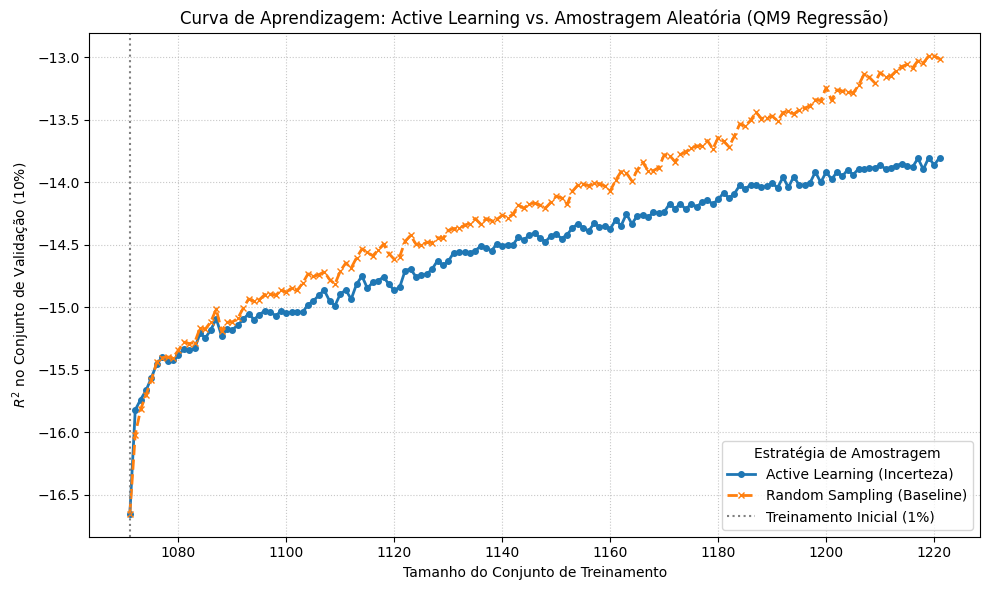


--- Resultados Finais ---
R² final (Active Learning) no Validação (10%): -13.8063
R² final (Random Sampling) no Validação (10%): -13.0135

--- Desempenho Final (Teste Final 10%) ---
R² (Active Learning): -13.4741
R² (Random Sampling): -12.6600


In [ ]:
# --- 6. PLOTAGEM DOS RESULTADOS ---

# O eixo X representa o número total de amostras de treinamento
num_samples = np.arange(n_initial, n_initial + len(acc_active) * BATCH_SIZE, BATCH_SIZE)
# Ajuste fino para garantir que o array tenha o mesmo tamanho que acc_active/acc_random
if len(num_samples) > len(acc_active):
    num_samples = num_samples[:len(acc_active)]
elif len(num_samples) < len(acc_active):
    num_samples = np.append(num_samples, num_samples[-1] + BATCH_SIZE)


plt.figure(figsize=(10, 6))
plt.plot(num_samples, acc_active, label='Active Learning (Incerteza)', color='#1f77b4', linewidth=2, marker='o', markersize=4)
plt.plot(num_samples, acc_random, label='Random Sampling (Baseline)', color='#ff7f0e', linestyle='--', linewidth=2, marker='x', markersize=4)

plt.axvline(x=n_initial, color='gray', linestyle=':', label='Treinamento Inicial (1%)')
plt.xlabel('Tamanho do Conjunto de Treinamento')
plt.ylabel(r'$R^2$ no Conjunto de Validação (10%)')
plt.title('Curva de Aprendizagem: Active Learning vs. Amostragem Aleatória (QM9 Regressão)')
plt.legend(title='Estratégia de Amostragem')
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n--- Resultados Finais ---")
print(f"R² final (Active Learning) no Validação (10%): {acc_active[-1]:.4f}")
print(f"R² final (Random Sampling) no Validação (10%): {acc_random[-1]:.4f}")

# Exibição do desempenho final no Conjunto de Teste Final (X_final_test)
print("\n--- Desempenho Final (Teste Final 10%) ---")
final_r2_active = evaluate_model(model_active, X_final_test, y_final_test)
final_r2_random = evaluate_model(model_random, X_final_test, y_final_test)
print(f"R² (Active Learning): {final_r2_active:.4f}")
print(f"R² (Random Sampling): {final_r2_random:.4f}")